### Capstone Project: Understanding and Predicting Crime in San Francisco, Part 2

by Elton Yeo, DSI13

In this section, we will predict the number of preventable crime given a specific date, day of the week, and hour, which will help the police plan their patrol schedules and resources. Police patrols are important because they project presence, which can deter criminals and increase the sense of safety for residents.

#### Contents:
- [Preprocessing](#Preprocessing)
- [Modelling](#Modelling)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)
- [Next Steps](#Next-Steps)

In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas
from shapely.geometry import Point
from pygeocoder import Geocoder

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

%matplotlib inline

### Preprocessing

#### Keeping preventable_crime only

As detailed in Part 1, such crimes are preventable with increased security presence and/or surveillance (whether through Police, community, and to a lesser extent, cameras) because they happen out in the open or can be easily observed. For example, robbery, burglary or snatch theft are less likely to occur if there is strong security presence in the area, because the culprit knows that he/she could be easily caught immediately after committing the crime. Areas with higher numbers of such crime would easily benefit from increased police patrols or community and tech surveillance measures.

Since the aim is to help police districts priortize their patrol resources, we will only predict the number of preventable crime given a specific zipcode, day of the week, and hour. 

In [163]:
#read in cleaned dataset
final_reports=pd.read_csv('../data/reports_cleaned.csv')

In [164]:
#extracting the necessary variables
final_reports=final_reports[['incident_date', 'incident_day_of_week', 
                       'incident_time', 'zip', 'incident_category']]

In [165]:
#checking our dataframe
final_reports.head()

,incident_date,incident_day_of_week,incident_time,zip,incident_category
0,2019/05/01,Wednesday,01:00,94122,preventable_crime
1,2019/06/22,Saturday,07:45,94103,non_violent_crime
2,2019/05/27,Monday,02:25,94123,violent_crime
3,2018/11/07,Wednesday,03:50,94103,preventable_crime
4,2019/08/15,Thursday,12:45,94115,preventable_crime


In [166]:
#confirming the current number of each incident category
final_reports.incident_category.value_counts()

preventable_crime     154868
non_violent_crime      75722
violent_crime          20316
white_collar_crime      9959
drug_crime              7648
Name: incident_category, dtype: int64

In [167]:
#keeping only preventable crime
final_reports=final_reports[final_reports.incident_category == 'preventable_crime']

In [168]:
#confirming that only preventable crimes are left 
final_reports.incident_category.value_counts()

preventable_crime    154868
Name: incident_category, dtype: int64

In [169]:
#replacing string with '1' for processing later
final_reports.incident_category.replace({'preventable_crime': 1},
                                       inplace=True)

In [170]:
#renaming  incident_category column to preventable_crime
final_reports.rename({'incident_category': 'preventable_crime'}, axis=1, inplace=True)

In [171]:
#confirming our edits to the dataframe
final_reports.head()

,incident_date,incident_day_of_week,incident_time,zip,preventable_crime
0,2019/05/01,Wednesday,01:00,94122,1
3,2018/11/07,Wednesday,03:50,94103,1
4,2019/08/15,Thursday,12:45,94115,1
9,2019/02/27,Wednesday,15:30,94111,1
11,2019/04/08,Monday,00:30,94115,1


#### Converting date and time to appropriate format and values

In [172]:
#converting incident_date to datetime format
final_reports.loc[:, 'incident_date'] = pd.to_datetime(final_reports['incident_date'])

#keeping only the year in incident_date for processing later
final_reports.loc[:, 'incident_date'] = final_reports.incident_date.apply(lambda x: x.year)

#creating new columne incident_hour by converting incident_time to datetime format
final_reports.loc[:, 'incident_hour'] = pd.to_datetime(final_reports['incident_time'])

#keeping only the hour in incident_hour
final_reports.loc[:, 'incident_hour'] = final_reports.incident_hour.apply(lambda x: x.hour)

In [173]:
#confirming our edits to the dataframe
final_reports.head()

,incident_date,incident_day_of_week,incident_time,zip,preventable_crime,incident_hour
0,2019,Wednesday,01:00,94122,1,1
3,2018,Wednesday,03:50,94103,1,3
4,2019,Thursday,12:45,94115,1,12
9,2019,Wednesday,15:30,94111,1,15
11,2019,Monday,00:30,94115,1,0


#### Splitting into train and test datasets

We will use 2018 data as our training data, and 2019 data as our testing data. We will ignore all 2020 data. 

In [174]:
#checking split of data by year
final_reports.incident_date.value_counts()

2018    71444
2019    70277
2020    13147
Name: incident_date, dtype: int64

In [175]:
#splitting into train and test datasets
train=final_reports[final_reports.incident_date == 2018]
test=final_reports[final_reports.incident_date == 2019]

#dropping incident_date column from both datasets
train.drop('incident_date', axis=1, inplace=True)
test.drop('incident_date', axis=1, inplace=True)

C:\Users\elton\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [176]:
#confirming number of rows in train dataset
train.shape

(71444, 5)

In [177]:
#confirming number of rows in test dataset
test.shape

(70277, 5)

In [178]:
#grouping the number of preventable_crime by day of week, zipcode, and hour of day in train dataset
train=train.groupby(['incident_day_of_week', 'zip', 'incident_hour']).sum().reset_index()

In [179]:
#viewing by highest number of preventable_crime to lowest
train.sort_values('preventable_crime', ascending=False).head()

,incident_day_of_week,zip,incident_hour,preventable_crime
2480,Thursday,94103,19,114
44,Friday,94103,20,108
1274,Saturday,94103,23,107
43,Friday,94103,19,107
3701,Wednesday,94103,19,93


In [180]:
#grouping the number of preventable_crime by day of week, zipcode, and hour of day in test dataset
test=test.groupby(['incident_day_of_week', 'zip', 'incident_hour']).sum().reset_index()

In [181]:
#viewing by highest number of preventable_crime to lowest
test.sort_values('preventable_crime', ascending=False).head()

,incident_day_of_week,zip,incident_hour,preventable_crime
3078,Tuesday,94103,18,92
1967,Sunday,94109,0,89
42,Friday,94103,18,88
12,Friday,94102,12,87
3669,Wednesday,94102,18,86


In [182]:
#save data to csv
train.to_csv('../data/train.csv', index=False)
test.to_csv('../data/test.csv', index=False)

In [183]:
#getting dummies from categorical data so that they can be processed by models
train = pd.get_dummies(train, columns = ['incident_day_of_week', 'zip', 'incident_hour'], drop_first=True)

#confirming that dummies have been created by checking the number of columns
train.shape

(4268, 56)

In [184]:
#getting dummies from categorical data so that they can be processed by models
test = pd.get_dummies(test, columns = ['incident_day_of_week', 'zip', 'incident_hour'], drop_first=True)

#confirming that dummies have been created by checking the number of columns
test.shape

(4262, 56)

### Modelling

We will use 5 regression models: linear regression, lassoCV,  ridgeCV, random forest with gridsearchCV, and XGBoost with gridsearchCV. 

We will establish a baseline mean squared error (MSE) score. All 5 models should have MSE scores that are lower than the baseline. This means that the models produced predictions which had a closer fit to the data. 

Among the 5 models, we will choose the best model by comparing r-squared scores. The higher the r-squared score, the better. R-squared also shows how close the data are to the fitted regression line; it is the percentage of the response variable variation that is explained by a model i.e. Explained variation / Total variation.
- 0% indicates that the model explains none of the variability of the response data around its mean.
- 100% indicates that the model explains all the variability of the response data around its mean.

For the final model which is chosen and used to predict from the test data, success is defined as:
- a MSE score higher than the baseline, which means that predictions had a closer fit to  the data than the baseline, and 
- a r-squared score of 0.8 and above, which means that the model explains 80% of the variability of the response data that is predictable from the independent variables.

#### Creating our train/test split and scaling

In [185]:
#create our features matrix X and target vector y
X = train.drop(['preventable_crime'], axis=1)
y = train['preventable_crime']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#scaling
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test) 

#### Baseline Mean Squared Error (MSE) score

In [186]:
#creating dataframe with number of preventable_crime and mean of preventable_crime as the baseline
base_df= pd.DataFrame(y_test)
base_df['baseline']= np.mean(y_test)
base_df.head()

,preventable_crime,baseline
1702,1,16.863168
1173,23,16.863168
308,12,16.863168
1322,13,16.863168
2570,21,16.863168


In [187]:
#calculating baseline MSE score
mean_squared_error(y_true=base_df.preventable_crime, y_pred=base_df.baseline)

247.07780927176287

#### Linear Regression

In [188]:
#instantiate our model
lr = LinearRegression()

#finding r-squared scores for linear regression
lr_score = cross_val_score(lr, X_train_sc, y_train, cv=10)
lr_score.mean()

0.7630160928049994

In [189]:
#fitting to our model
lr.fit(X_train_sc, y_train)

#finding r-squared scores for linear regression on X_test_sc
lr.score(X_test_sc, y_test)

0.7334677625814559

In [190]:
#using model to predict from X_test
y_pred_lr=lr.predict(X_test_sc)

#finding mse for linear regression
mean_squared_error(y_test, y_pred_lr)

65.85420132167526

#### LassoCV

In [191]:
#instantiate our model and find optimal alpha
lasso = LassoCV(n_alphas=500)

#fitting to lasso
lasso.fit(X_train_sc, y_train)

#input optimal alpha
lasso_opt = Lasso(lasso.alpha_)

#finding r-squared scores for lasso
lasso_score = cross_val_score(lasso_opt, X_train_sc, y_train)
lasso_score.mean()

C:\Users\elton\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\elton\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7647805078966549

In [192]:
#fitting to lasso with optimal alpha
lasso_opt.fit(X_train_sc, y_train)

#finding r-squared scores for lasso on X_test_sc
lasso_opt.score(X_test_sc, y_test)

0.7340243991880419

In [193]:
#using model to predict from X_test
y_pred_lasso=lasso_opt.predict(X_test_sc)

#finding mse for lasso 
mean_squared_error(y_test, y_pred_lasso)

65.71666876835954

#### RidgeCV

In [194]:
#instantiate our model and find optimal alpha
ridge_alphas=np.logspace(0, 5, 200)
ridge = RidgeCV(alphas=ridge_alphas)

#fitting to ridge
ridge.fit(X_train_sc, y_train)

#input optimal alpha
ridge_opt= Ridge(alpha=ridge.alpha_)

#finding r-squared scores for ridge on X_train_sc
ridge_score = cross_val_score(ridge_opt, X_train_sc, y_train)
ridge_score.mean()

C:\Users\elton\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7647855711923855

In [195]:
#fitting to ridge with optimal alpha
ridge_opt.fit(X_train_sc, y_train)

#finding r-squared scores for ridge on X_test_sc
ridge_opt.score(X_test_sc, y_test)

0.7336498682232815

In [196]:
#using model to predict from X_test
y_pred_ridge=ridge_opt.predict(X_test_sc)

#finding mse for ridge
mean_squared_error(y_test, y_pred_ridge)

65.80920705863697

#### Random Forest with GridSearchCV

In [197]:
#determining range of hyperparamters
rf_parameters={
        'max_depth': np.arange(25, 30),
        'n_estimators': np.arange(15, 20),
        'min_samples_split': [2,4,6,8,10]
}

#instantiate our model
rf=GridSearchCV(RandomForestRegressor(), 
                      rf_parameters,
                      verbose=1)

#fitting our data to our model
rf.fit(X_train_sc, y_train)

C:\Users\elton\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:   48.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([25, 26

In [198]:
#best r2 score from GridsearchCV
rf.best_score_

0.7399085155978893

In [199]:
#using best hyperparameters to get r2 score on X_test_sc and y_test
best_rf=rf.best_estimator_
best_rf.score(X_test_sc, y_test)

0.8063700091695774

In [200]:
#using model to predict from X_test
y_pred_rf=best_rf.predict(X_test_sc)

#finding mse for random forest model with best hyperparameters
mean_squared_error(y_test, y_pred_rf)

47.84167394369236

#### XGBoost with GridSearchCV

In [201]:
#determining range of hyperparamters
xgb_parameters={
        'max_depth': [1,3,5,7],
        'n_estimators': [500, 550, 600], 
        'learning_rate': [0.2, 0.4, 0.6, 0.8]
}

#instantiate our model
xgb=GridSearchCV(XGBRegressor(), 
                      xgb_parameters,
                      verbose=1)

#fitting our data to our model
xgb.fit(X_train_sc, y_train)

C:\Users\elton\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  3.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_cons...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_p

In [202]:
#best r2 score from GridsearchCV
xgb.best_score_

0.8298653572877429

In [203]:
#using best hyperparameters to get r2 score on X_test_sc and y_test
best_xgb=xgb.best_estimator_
best_xgb.score(X_test_sc, y_test)

0.8451533929561439

In [204]:
#using model to predict from X_test
y_pred_xgb=best_xgb.predict(X_test_sc)

#finding mse for XGBoost model with best hyperparameters
mean_squared_error(y_test, y_pred_xgb)

38.259160441561505

#### Final model predicton and evaluation

Among our five models, XGBoost had the lowest MSE score of 38 (beating the baseline of 247) and the highest r-squared score of 0.85 when predicting from X_test of our train set which contains 2018 data. 

We will proceed to use this XGBoost model with best hyperparameters to predict and score our test set which contains 2019 data. 

In [205]:
#creating X and y from our test set
X_valid = test.drop(['preventable_crime'], axis=1)
y_valid = test['preventable_crime']

#scaling X_valid_sc according to X_train
X_valid_sc = ss.transform(X_valid)

In [206]:
#using best hyperparameters to get r2 score on X_valid_sc and y_valid
best_xgb.score(X_valid_sc, y_valid)

0.8022793805526838

In [207]:
#using model to predict from X_valid
y_pred_xgb2=best_xgb.predict(X_valid_sc)

#finding mse for XGBoost model with best hyperparameters
mean_squared_error(y_valid, y_pred_xgb2)

43.95442581927804

Using the test data, our final model had a MSE score of 44 (beating the baseline of 247) and a r-squared score of 0.80, which means that the model explains 80% of the variability of the response data that is predictable from the independent variables.

#### Understanding Feature Importance

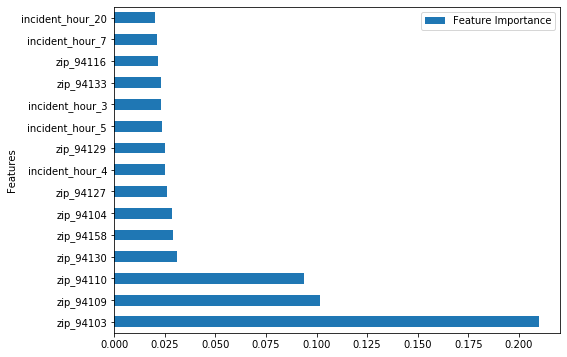

In [208]:
#creating dataframe with independent variables and corresponding importance in our final model
feat_impt=pd.DataFrame({'Features': X.columns,
             'Feature Importance': best_xgb.feature_importances_
             }).sort_values('Feature Importance', ascending=False).head(15)

#plotting feature importance
feat_impt.plot.barh(x='Features', figsize=(8,6))

The above bar graphs shows that zipcodes were of the highest importance in predicting the number of preventable crime given the day of week, hour of the day, and zipcode. 

It would be worth further investigating the characteristics of the various zipcodes which may have contributed to the number of preventable crimes in each zipcode and the variance across zipcodes. 

#### Residual Plot

The difference between the observed value of the dependent variable (y) and the predicted value (ŷ) is called the residual. A residual plot is a graph that shows the residuals on the vertical axis and the independent variable on the horizontal axis. 

Our residual plot for the predicted values generated by our final model from our test data shows that most of the differences between the true number of preventable crime and predicted number of preventable crime are clustered around 0, which indicates that our model is generally working. But at higher values of preventable crime, the model did not do as well as it did at lower values of preventable crime. This could likely be improved by gathering more data to train our model on. 

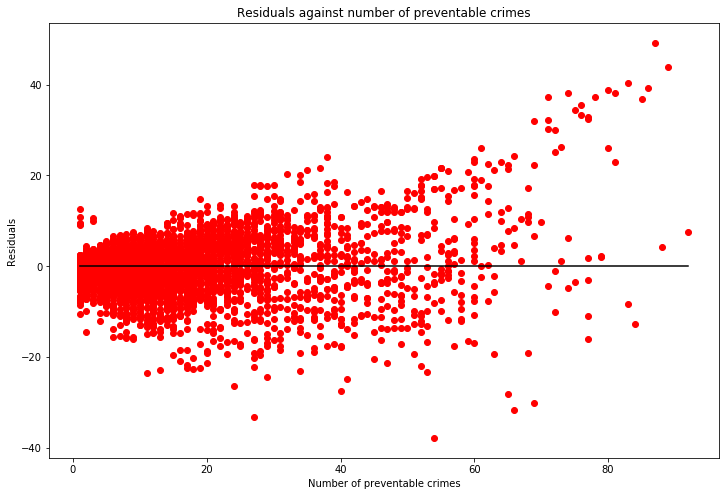

In [209]:
#residual plot
xgb_resid = y_valid - best_xgb.predict(X_valid_sc)

#Set figure size, title, x and y labels
plt.figure(figsize=(12,8))
plt.title('Residuals against number of preventable crimes')
plt.ylabel('Residuals')
plt.xlabel('Number of preventable crimes')

#Plot the scatter of residuals against the true values of sale price
plt.scatter(y=xgb_resid, x=y_valid, c='r')

#Plot the line y=0
plt.plot([np.min(y_valid),np.max(y_valid)],[0,0], c='k');

### Conclusion and Recommendations

#### Objective 1: Understanding different types of crime in San Francisco

The aim was to develop insights into the areas with the most crimes, and consider policy and operational measures which might help to bring down crime in those areas based on those insights.

We learnt that:
- zipcode 94111 had the highest number of total and preventable crime per capita in all of SF city. This zipcode corresponds with Embarcadero and the Financial District, which houses mainly offices and shopping malls. 
- zipcode 94103 had the highest number of violent, non-violent and drug crime per capita in all of SF city. This zipcode corresponds with parts of the Tenderloin neighborhood, which is notorious for gangs and drug crime. It is unsurprising that it has the highest number of such crime per capita. (https://en.wikipedia.org/wiki/Tenderloin,_San_Francisco) 
- zipcode 94104 had the highest number of white-collar crime per capita in all of SF city. This zipcode corresponds with a small area of offices in the financial district. Based on GoogleMaps, it appears that only office buildings are found within that zipcode, which might explain why white-collar crime per capita is the highest there, compared with other zipcodes which have a mix of building types e.g. malls, shops, residential. 

These insights are useful for the SF mayor, Police Commanders and district supervisors, and are the starting point for further investigation and analysis to finetune policies and operational methods. For example, within 94104, we could consider which buildings contributed to the most white-collar crime, why, and how to address the specific cause. Across zipcodes which have similar building demographics e.g. 94112 and 94134 which both mainly comprise residential buildings, we could ask why 94134 has almost two times the number of violent crime, and consider if measures implemented in 94112 could be implemented in 94134 as well. We could also consider diverting more resources in addressing drug crime to zipcode 94103, or set up a dedicated drug crime taskforce there. 

#### Objective 2: Predicting the number of preventable crime in San Francisco

The aim was to predict the number of preventable crime given a specific zipcode, day of the week, and hour, which will help the police plan their patrol schedules and resources. We managed to predict the number of preventable crime well using the XGBoost model, with a r-squared score of 0.8.

Police patrols are important because they project presence, which can deter criminals and increase the sense of safety for residents.

We will consider some actual steps that the San Francisco Police can take using the predicted numbers. 

In [210]:
#read in test dataset again
test2=pd.read_csv('../data/test.csv')

In [211]:
#add column of predicted number of preventable crime to test dataset
test2['xgb_predict']=y_pred_xgb2

There are approximately 52 weeks in a year, which means 52 days of each week. We will divide our number of crimes (both actual and predicted) by 52. This will tell us the predicted number of preventable crime on that particular day of the week, at that particular hour and zipcode. 

In [212]:
#divide actual and predicted number of crimes by 52
test2.preventable_crime=test2.preventable_crime/52
test2.xgb_predict=test2.xgb_predict/52

In [213]:
#viewing by highest number of predicted preventable crime to lowest
test2.sort_values('xgb_predict', ascending=False).head(10)

,incident_day_of_week,zip,incident_hour,preventable_crime,xgb_predict
2470,Thursday,94103,19,1.326923,1.907094
1260,Saturday,94103,19,1.269231,1.876870
43,Friday,94103,19,1.615385,1.858716
3079,Tuesday,94103,19,1.250000,1.791903
1259,Saturday,94103,18,1.480769,1.787161
1871,Sunday,94103,19,1.038462,1.766315
3694,Wednesday,94103,19,1.596154,1.757343
1261,Saturday,94103,20,1.480769,1.690898
648,Monday,94103,19,1.307692,1.676706
3078,Tuesday,94103,18,1.769231,1.623973


Based on the above table, the San Francisco police can expect approximately 1 to 2 crimes to take place in the evening hours (6 to 8pm) of most days (with Saturday being a bit more frequent) at zipcode 94103. Therefore, they should send more resources to patrol zipcode 94103 during such evening hours to prevent such crime from taking place, and calibrate their resources for other zipcodes, days of the week, and hours accordingly. 

### Next Steps

For objective 1:
- We should gather demographic data (population size, breakdown by age, employment status, profile, race etc.) for each zipcode, police district, and supervisor district so that we can tailor the analysis for each police commander and supervisor. The additional variables may also give rise to new insights or correlations which could be the impetus for taking different policy or operational approaches. 
- We should include data from previous years for sharper insights. 

For objective 2: 
- Similarly, we should gather demographic data which may be able to sharpen our model. We could also use it to help us understand which other variables have a strong influence on the number of preventable crimes in an area, which could give rise to new policy or operational approaches. 
- We should include data from previous years for sharper predictions. 

Besides quantitative data analysis, we should also corroborate our insights and findings with qualitative experiences of Police officers and policymakers who know the ground. Their experiences can augment the recommendations that arise from our quantitative analysis, and capture realities that may not be observable through quantitative data. 